<a href="https://colab.research.google.com/github/Aleena24/real-image-SRGAN/blob/main/research_srgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# importing libraries

In [ ]:
import glob
import os
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.layers import *
from tensorflow.keras import Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Residual Block

Residual Block is used to overcome the degradation problem which means when we add more layers, the performance of the network gets worse instead of better.

In [ ]:
def residual_block(x):
    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size,strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size,strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Add()([res, x])
    return res

# Generator Network
commonly used in tasks like image super-resolution or image-to-image translation. Here with a combination of convolutional, residual, upsampling, and activation layers to transform input data into a desired output, such as high-resolution images.


In [ ]:
def build_generator(gen_input):

    residual_blocks = 16
    momentum = 0.8
    # Input Layer of the generator network
    input_layer = gen_input

    # Adding the pre-residual block
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same',activation='relu')(input_layer)

    # Adding 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)

    # Adding the post-residual block
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)

    # sum of the output from the pre-residual block(gen1) and the post-residual block(gen2)
    gen3 = Add()([gen2, gen1])

    # Adding an upsampling block
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)

    # Adding another upsampling block
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1,
                  padding='same')(gen5)
    gen5 = Activation('relu')(gen5)

    # Output convolution layer
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)

    # Keras model
    model = Model(inputs=[input_layer], outputs=[output],
                  name='generator')
    return model

# Discriminator Network

 discriminator network is designed to classify images as real or fake. It achieves this by applying convolutional operations to extract features from the input images and then using dense layers for classification. The use of LeakyReLU activation functions helps in preventing the network from getting stuck during training, and batch normalization aids in stabilizing the training process.


In [ ]:
def build_discriminator(dis_input):

    leakyrelu_alpha = 0.2
    momentum = 0.8

    input_layer = dis_input

    # Adding the first convolution block
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    # Adding the 2nd convolution block
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    # Adding the third convolution block
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    # Adding the fourth convolution block
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    # Adding the fifth convolution block
    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    # Adding the sixth convolution block
    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    # Adding the seventh convolution block
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    # Adding the eight convolution block
    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)

    # Adding a dense layer
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)

    # dense layer - for classification
    output = Dense(units=1, activation='sigmoid')(dis9)

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

# Adversial Network
the adversarial model combines the generator, discriminator, and VGG network. The generator aims to produce high-resolution images from low-resolution inputs, while the discriminator evaluates the generated images. The VGG network helps to capture the content of the generated images. During training, the discriminator's weights are fixed to focus on improving the generator's performance.


In [ ]:
def build_adversarial_model(generator, discriminator, vgg):

    input_low_resolution = Input(shape=(64, 64, 3))

    fake_hr_images = generator(input_low_resolution)
    fake_features = vgg(fake_hr_images)

    discriminator.trainable = False

    output = discriminator(fake_hr_images)

    model = Model(inputs=[input_low_resolution],
                  outputs=[output, fake_features])

    for layer in model.layers:
        print(layer.name, layer.trainable)

    return model

In [ ]:
def build_vgg(high_resolution_shape):
    vgg = VGG19(weights = 'imagenet', include_top=False, input_shape=high_resolution_shape)

    return Model(inputs = vgg.inputs, outputs = vgg.layers[10].output)

def create_combination(generator,discriminator,vgg,input_low_resolution,input_high_resolution):
    generated_high_resolution_images = generator(input_low_resolution)

    features = vgg(generated_high_resolution_images)

    discriminator.trainable = False

    probs = discriminator(generated_high_resolution_images)

    adversarial_model = Model(inputs=[input_low_resolution, input_high_resolution], outputs=[probs, features])

    return adversarial_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
n = 100
lr_images = []
hr_images = []

lr_dir = "/content/drive/MyDrive/research_dataset/BSD100"
hr_dir = "/content/drive/MyDrive/research_dataset/BSD100"

common_width = 256
common_height = 256

def resize_image(image, width, height):
    return cv2.resize(image, (width, height))

for img_name in os.listdir(lr_dir)[:n]:
    img_path = os.path.join(lr_dir, img_name)
    img_lr = cv2.imread(img_path)
    if img_lr is not None:
        img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
        img_lr = resize_image(img_lr, common_width, common_height)
        lr_images.append(img_lr)
        print("LR image shape:", img_lr.shape)
    else:
        print(f"Failed to read image: {img_path}")

for img_name in os.listdir(hr_dir)[:n]:
    img_path = os.path.join(hr_dir, img_name)
    img_hr = cv2.imread(img_path)
    if img_hr is not None:
        img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
        img_hr = resize_image(img_hr, common_width, common_height)
        hr_images.append(img_hr)
        print("HR image shape:", img_hr.shape)
    else:
        print(f"Failed to read image: {img_path}")

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

print("Low-resolution images shape:", lr_images.shape)
print("High-resolution images shape:", hr_images.shape)


LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image s

<ipython-input-9-61f543aa3bd8>:12: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  upscaled_lr_image = rescale(lr_images[image_number], scale=4, mode='constant', multichannel=True, anti_aliasing=True)


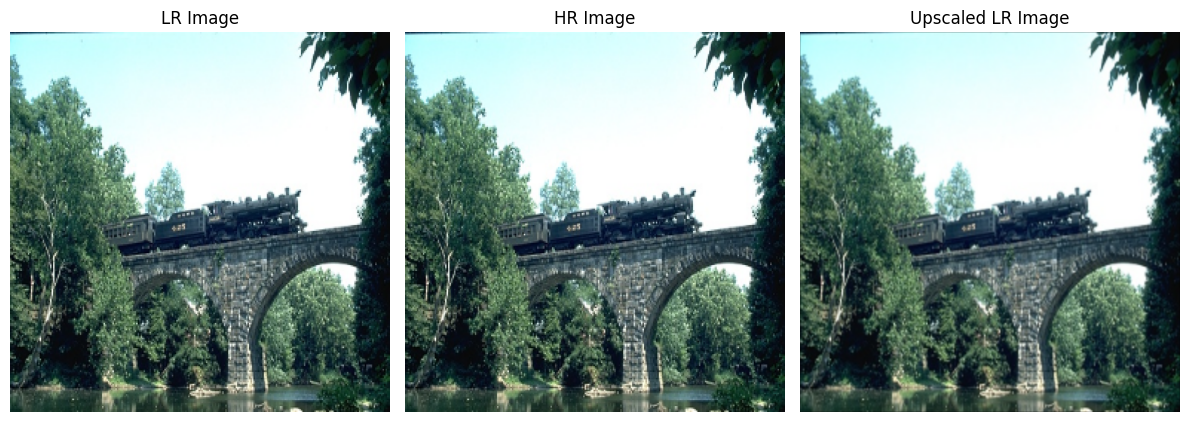

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import rescale

# Assuming lr_images and hr_images are your LR and HR image datasets, respectively

# Randomly select an image number
image_number = random.randint(0, len(lr_images) - 1)

# Upscale the LR image using bicubic interpolation
upscaled_lr_image = rescale(lr_images[image_number], scale=4, mode='constant', multichannel=True, anti_aliasing=True)

# Set up the figure
plt.figure(figsize=(12, 6))

# Display LR image
plt.subplot(131)
plt.title('LR Image')
plt.imshow(lr_images[image_number])
plt.axis('off')

# Display HR image
plt.subplot(132)
plt.title('HR Image')
plt.imshow(hr_images[image_number])
plt.axis('off')

# Display Upscaled LR image
plt.subplot(133)
plt.title('Upscaled LR Image')
plt.imshow(upscaled_lr_image)
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#Scale values
lr_images = lr_images/255
hr_images = hr_images/255

In [ ]:
#Train test Split
from sklearn.model_selection import train_test_split

lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images,hr_images,test_size=0.3,random_state=100)

low_resolution_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])
high_resolution_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])

In [ ]:
# Shape of low-resolution and high-resolution images
input_low_resolution = Input(shape=low_resolution_shape)
input_high_resolution = Input(shape=high_resolution_shape)

In [ ]:
generator = build_generator(input_low_resolution)
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         15616     ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d_1[0][0]']            
                                                                                          

In [ ]:
# Common optimizer for all networks
common_optimizer = Adam(0.0002, 0.5)
discriminator = build_discriminator(input_high_resolution)
discriminator.compile(loss='mse', optimizer=common_optimizer,
                      metrics=['accuracy'])
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 batch_normalization_33 (Ba  (None, 128, 128, 64)      256       
 tchNormalization)                                               
                                                     

In [ ]:
vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
gan_model = create_combination(generator,discriminator,vgg,input_low_resolution,input_high_resolution)
gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=[1e-3, 1],
                  optimizer=common_optimizer)
gan_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 generator (Functional)      (None, 1024, 1024, 3)        2042691   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 discriminator (Functional)  (None, 16, 16, 1)            5219137   ['generator[0][0]']           
                                                                                            

In [ ]:
adv_model = build_adversarial_model(generator,discriminator,vgg)
adv_model.compile(loss=["binary_crossentropy","mse"], loss_weights=[1e-3, 1],
                  optimizer=common_optimizer)
adv_model.summary()

input_4 True
generator True
discriminator False
model False
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 generator (Functional)      (None, 1024, 1024, 3)        2042691   ['input_4[0][0]']             
                                                                                                  
 discriminator (Functional)  (None, 16, 16, 1)            5219137   ['generator[1][0]']           
                                                                                                  
 model (Functional)          (None, 32, 32, 256)          2325568   ['generator[1][0]']           
                                

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define directories
lr_dir = "/content/drive/MyDrive/research_dataset/BSD100"
hr_dir = "/content/drive/MyDrive/research_dataset/BSD100"

# Load and preprocess images
n = 100
lr_images = []
hr_images = []

common_width = 256
common_height = 256

def resize_image(image, width, height):
    return cv2.resize(image, (width, height))

for img_name in os.listdir(lr_dir)[:n]:
    img_path = os.path.join(lr_dir, img_name)
    img_lr = cv2.imread(img_path)
    if img_lr is not None:
        img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
        img_lr = resize_image(img_lr, common_width, common_height)
        lr_images.append(img_lr)
        print("LR image shape:", img_lr.shape)
    else:
        print(f"Failed to read image: {img_path}")

for img_name in os.listdir(hr_dir)[:n]:
    img_path = os.path.join(hr_dir, img_name)
    img_hr = cv2.imread(img_path)
    if img_hr is not None:
        img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
        img_hr = resize_image(img_hr, common_width, common_height)
        hr_images.append(img_hr)
        print("HR image shape:", img_hr.shape)
    else:
        print(f"Failed to read image: {img_path}")

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

print("Low-resolution images shape:", lr_images.shape)
print("High-resolution images shape:", hr_images.shape)

# Normalize images
lr_images = lr_images / 255.0
hr_images = hr_images / 255.0

# Train-test split
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.3, random_state=100)

print("Low-resolution train images shape:", lr_train.shape)
print("High-resolution train images shape:", hr_train.shape)
print("Low-resolution test images shape:", lr_test.shape)
print("High-resolution test images shape:", hr_test.shape)


LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image shape: (256, 256, 3)
LR image s

In [ ]:
generator.save('gen_e_10.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 47s 47s/step


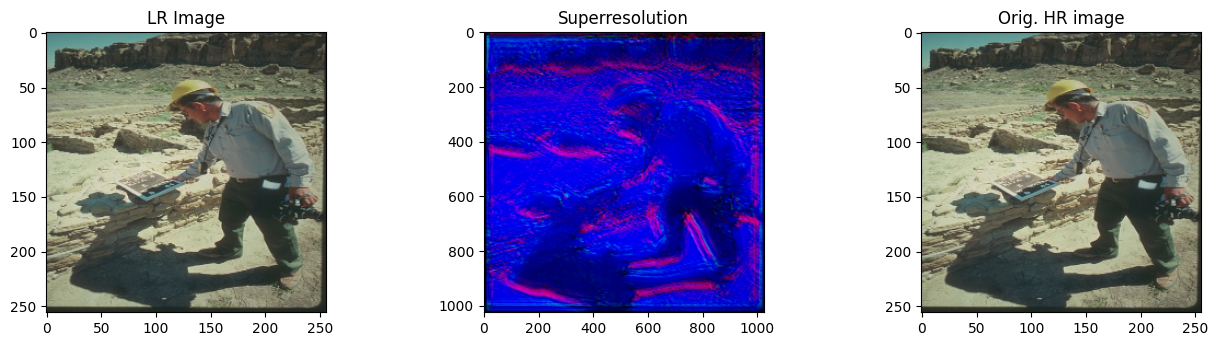

1/1 [==============================] - 109s 109s/step


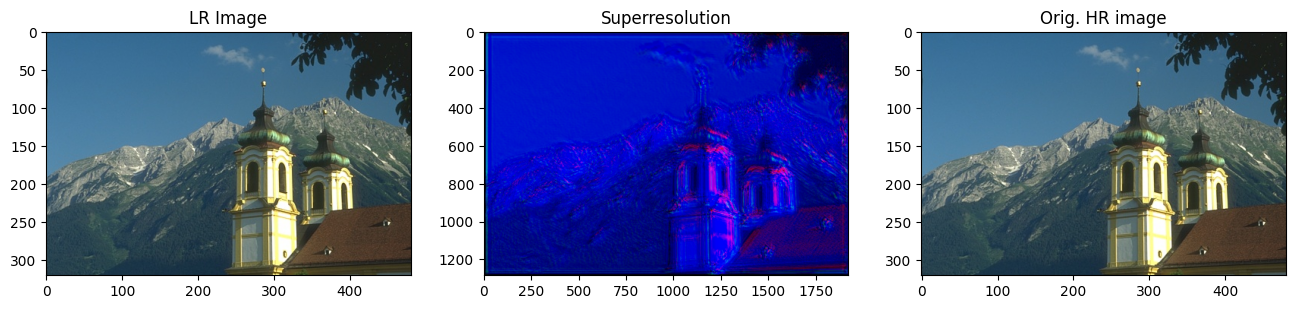

In [ ]:
from tensorflow.keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_10.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

sreeni_lr = cv2.imread("/content/drive/MyDrive/research_dataset/BSD100/126007.png")
sreeni_hr = cv2.imread("/content/drive/MyDrive/research_dataset/BSD100/126007.png")

#Change images from BGR to RGB for plotting.
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()